# Amazon Fine Food Reviews Analysis
The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454
Number of users: 256,059
Number of products: 74,258
Timespan: Oct 1999 - Oct 2012
Number of Attributes/Columns in data: 10

Attribute Information:

* Id
* ProductId - unique identifier for the product
* UserId - unqiue identifier for the user
* ProfileName
* HelpfulnessNumerator - number of users who found the review helpful
* HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
* Score - rating between 1 and 5
* Time - timestamp for the review
* Summary - brief summary of the review
* Text - text of the review

# Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).


[Q] How to determine if a review is positive or negative?

[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazon-fine-food-reviews/database.sqlite


In [3]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize

from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve,auc
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# SQL Lite to read the data

In [4]:
con=sqlite3.connect('../input/amazon-fine-food-reviews/database.sqlite')

filtered_data=pd.read_sql_query(""" 
    SELECT * 
    FROM Reviews
    WHERE Score !=3""", con)

**GIve Review** with score>3  a **possitive** rating and below 3 as **Negative **

In [5]:
def partition(x):
    if x<3:
        return 'negative'
    return 'positive'

actualScore=filtered_data['Score']
positiveNegative=actualScore.map(partition)
filtered_data['Score']=positiveNegative

In [6]:
filtered_data.shape

(525814, 10)

In [7]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Data Cleaning: Duplication
Here it is found duplication of the data 

In [8]:
display=pd.read_sql_query(""" 
 SELECT *
 FROM Reviews
 WHERE Score !=3 AND UserId="A395BORC6FGVXV"
 ORDER BY ProductID
 """, con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,544173,B000U9WZ54,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
1,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
2,136304,B002Y7526Y,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...


Here we can see that "A395BORC6FGVXV" has similar review and rating . These are the duplicate which should be removed from here 

> Sorting the data according to ProductId in ascending Order

In [9]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True,inplace=False, kind="quickshot", na_position="last")

# Droping Duplicates

In [10]:
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep="first",inplace=False)
final.shape

(364173, 10)

In [11]:
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

# Observation
It was also seen that in two rows given below the value of helpfulnessNumerator is geater than HelpfulnessDenominator which is not possible

In [12]:
display=pd.read_sql_query("""
SELECT *
FROM Reviews 
WHERE Score != 3 AND Id=44737 or Id=6422
ORDER BY ProductId
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
1,6422,B001UOY7X6,A1UHSQI6HLMUJA,Cooker,0,0,5,1287273600,Amazing cooking chocolate,This is amazing chocolate for most baking. Man...


# HelpfulnessNumerator	=Yes
# HelpfulnessDenominator=Yes+No	

In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
print(final.shape)

(364171, 10)


In [15]:
final['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [16]:
final.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

# Bag of Word(BoW)

# Bi-Grams and n-Grams

# Text Preprocessing: Stemming, stop-word removal and Lemmatization.
Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

Begin by removing the html tags
Remove any punctuations or limited set of special characters like , or . or # etc.
Check if the word is made up of english letters and is not alpha-numeric
Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
Convert the word to lowercase
Remove Stopwords
Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)
After which we collect the words used to describe positive and negative reviews

In [17]:
# find sentence containg HTML tags
import re
i=0
for sent in final['Text'].values:
    if(len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break
        ;
    i+=1
    

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [18]:
import re
# for regular expression tutorials https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop=set(stopwords.words('english'))
sno=nltk.stem.SnowballStemmer('english')

def cleanhtml(sentence):
    cleanr=re.compile('<.*?>')
    cleantext=re.sub(cleanr,'',sentence)
    return cleantext

def cleanpunch(sentence):
    cleaned=re.sub(r'[/|!|\'|"|#|]','r', sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned

print(stop)

print('***********************************************************************************')
print(sno.stem('tasty'))
print(sno.stem('very'))

{'while', 'why', 'which', 'its', 'most', 'mustn', 'won', 'how', 'to', 'ain', 'here', "won't", "hadn't", "it's", 'than', 'ours', 'when', 'nor', 'that', 'or', 'as', "you'll", "you've", 'the', 'so', 'you', 'do', 'at', 'll', 'down', 'hers', 'any', 'hadn', 'm', 'yourself', 'these', 'whom', 'ma', 'he', 'don', 'have', 'has', "doesn't", 'wasn', 'myself', 's', 'my', 'this', 'those', 'weren', 'haven', 'was', 'under', 'all', "wasn't", 'only', 'because', 'them', 'had', 'on', 'being', 'but', "couldn't", "hasn't", 'of', 'who', 'off', "haven't", 'up', 'your', 'it', 'i', 'own', 'themselves', 'other', 'for', 'mightn', 'are', 'over', 'our', 'then', 'very', 'should', 'their', 'each', 'can', "should've", 'couldn', 'by', 'is', 'few', "she's", 'herself', "you're", "mustn't", 'doing', 'be', 'will', 'himself', 'both', 'were', 'against', 'me', 'ourselves', 'from', 'now', 're', "shan't", 'above', 'until', 'just', 'didn', 'her', 'theirs', 'no', 'and', 'having', "wouldn't", 'she', 'again', 'been', "didn't", 'need

In [19]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
i=0
str1=' '
final_string=[]
all_positive_words=[]
all_negative_words=[]
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunch(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if(final['Score'].values)[i]=='positive':
                        all_positive_words.append(s)
                    if(final['Score'].values)[i]=='negative':
                        all_negative_words.append(s)
                    
                else:
                    continue
            else:
                continue
    str1=b" ".join(filtered_sentence)
    
    final_string.append(str1)
    i+=1
    
    

In [20]:
final['CleanedText']=final_string  #adding a column of CleanedText which displays the data after pre-processing of the review 

In [21]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month yearr learn poe...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


In [22]:
final.head(3) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

# Bag of Words (BoW)

In [23]:
# To get 2k +ve and 2k -ve reviews randomly.

data_pos = final[final["Score"] == "positive"].sample(n = 2000)
data_neg = final[final["Score"] == "negative"].sample(n = 2000)
final_4000 = pd.concat([data_pos, data_neg])

In [24]:
data_pos.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
5199,5637,B000EUJLHE,AGT4AMNGOIYSM,Mysstryss,0,0,positive,1349222400,True To Their Name,These crackers are certainly Crisp and Light. ...,b'cracker certain crisp light eater happi some...
58894,63977,B004IXYLJ6,A16H3JNMR9EWLA,Gaius Julius Ceasar,2,2,positive,1329436800,Simple...,The best store bought brownie mix. Just add oi...,b'best store bought browni mix add oil water e...
407206,440333,B005ZBZLSU,A7ZB1DJCNU1SU,Angela Bunke,1,1,positive,1327881600,Love this stuff!,I really like this coffee - no problem with th...,b'realli like coffe problem bag open long gone...
252307,273538,B001CCU8F2,A1KNF8V0TT4LW2,"W. Hoyt ""Pee Wee Shooter""",0,4,positive,1318982400,Not difficult to get a refund if you were tric...,"First off I have no idea how good these ""pods""...",b'first idea good rpodsr howev got done rlive ...
250479,271587,B0027E4OH2,A1D0N7I6OHX3WU,firsttimemom,0,0,positive,1306454400,Great Taste and Price,This juice is one of my baby's favorites. I us...,b'juic one babyr favorit use buy bottl way che...


In [25]:
data_neg.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
335702,363231,B000SATGHK,A3OC1NSL2PPK0S,L. Feng,4,12,negative,1258329600,Incompetent,This is probably one of the most incompetent c...,b'probabl one incompet compani ever order firs...
355121,384105,B002AMRNNI,A34O777PNTFSP8,teddys mom,0,0,negative,1343260800,Bad Sauce,"The pasta is delicious, but the sauce is nasty...",b'pasta delici sauc nasti bitter littl chees f...
126520,137283,B000KSTYBS,A2AKOCXD26DH0O,"Brek Renzelman ""violist""",3,10,negative,1315526400,2 lbs. of $20+ compost,"Yes, I am a coffee snob. But this is only beca...",b'yes coffe snob discov much enjoy differ gain...
290522,314733,B001M0A6C4,A24GX20L2H7S0I,"Angeline Dorsey ""angie""",4,4,negative,1344816000,THE PRICE??!,What on Earth am I missing here? Almost 6 buck...,b'earth miss almost buck regular anyon help fi...
218710,237085,B004ZU0RAE,AFUET4TIS1BF4,Ashlee,0,0,negative,1238544000,Didn't like these at all,"I hardly ever write negative reviews, but I ho...",b'hard ever write negat review hope save someo...


In [26]:
score_4000=final_4000['Score']

In [27]:
score_4000.shape

(4000,)

In [28]:
final_4000.shape

(4000, 11)

In [29]:
count_vect=CountVectorizer()
final_counts=count_vect.fit_transform(final_4000['CleanedText'].values)

In [30]:
type(final_counts)

scipy.sparse.csr.csr_matrix

In [31]:
final_counts.shape

(4000, 11348)

# Bi-Grams and n-Grams.
> Motivation

Now that we have our list of words describing positive and negative reviews lets analyse them.

We begin analysis by getting the frequency distribution of the words as shown below

In [32]:
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)

print("Most Common Possitive words: ",freq_dist_positive.most_common(20))
print("Most Common Negative words: ",freq_dist_negative.most_common(20))

Most Common Possitive words:  [(b'like', 138738), (b'tast', 126565), (b'good', 108080), (b'flavor', 106721), (b'love', 106500), (b'use', 103344), (b'great', 98659), (b'one', 94731), (b'product', 86887), (b'tri', 85588), (b'itr', 84787), (b'tea', 80932), (b'coffe', 76162), (b'make', 74733), (b'get', 71751), (b'food', 62782), (b'would', 55411), (b'time', 53933), (b'buy', 53511), (b'realli', 52450)]
Most Common Negative words:  [(b'tast', 34012), (b'like', 32207), (b'product', 27481), (b'one', 20207), (b'flavor', 18903), (b'would', 17931), (b'tri', 17673), (b'use', 15190), (b'good', 14688), (b'coffe', 14261), (b'get', 13734), (b'buy', 13579), (b'order', 12757), (b'food', 12342), (b'itr', 12078), (b'tea', 11315), (b'donrt', 11102), (b'even', 11045), (b'box', 10574), (b'make', 9806)]


> Observation:- From the above it can be seen that the most common positive and the negative words overlap for eg. 'like' could be used as 'not like' etc.
So, it is a good idea to consider pairs of consequent words (bi-grams) or q sequnce of n consecutive words (n-grams)

In [33]:
#bi-gram, tri-gram and n-gram
#removing stop words like "not" should be avoided before building n-grams

count_vect=CountVectorizer(ngram_range=(1,2))
final_bigram_counts=count_vect.fit_transform(final_4000['CleanedText'].values)


In [34]:
final_bigram_counts.shape

(4000, 122354)

In [35]:
final_bigram_counts.get_shape()

(4000, 122354)

In [36]:
from sklearn.preprocessing import StandardScaler

std_data=StandardScaler(with_mean=False).fit_transform(final_bigram_counts)
std_data.shape

(4000, 122354)

In [37]:
type(std_data)

scipy.sparse.csr.csr_matrix

In [38]:
std_data=std_data.todense()

> Sparse vectors are when you have a lot of values in the vector as zero. While a dense vector is when most of the values in the vector are non zero

In [39]:
type(std_data)

numpy.matrix

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


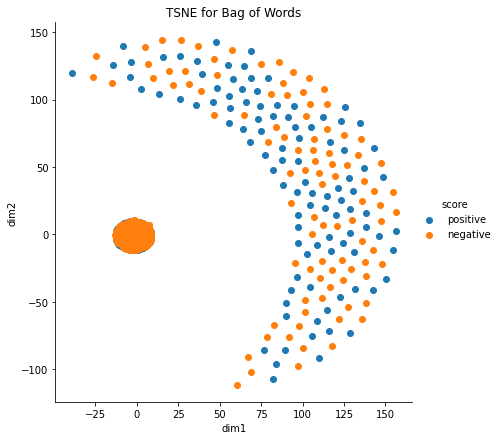

In [40]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 30, n_iter = 5000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(std_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_4000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for Bag of Words")
plt.show()

# Observation:- 
> Here, we are unable to simply draw a hyperplane and separate +ve and -ve reviews because it overlap each other. But we will have some alternative way to separates review.

# TF-IDF

In [41]:
# Tf-Idf
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final_4000['CleanedText'].values)

In [42]:
# Standardization 
from sklearn.preprocessing import StandardScaler
std = StandardScaler(with_mean = False)
std_data = std.fit_transform(final_tf_idf)

In [43]:
# Converting sparse matrix to dense because tnse takes dense vector
std_data = std_data.todense()

In [44]:
std_data.shape


(4000, 122354)

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


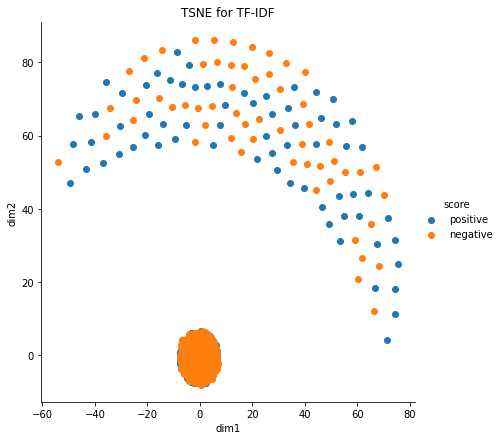

In [45]:
# tsne
from sklearn.manifold import TSNE
model = TSNE(n_components = 2, perplexity = 50)
tsne_data = model.fit_transform(std_data)

tsne_data = np.vstack((tsne_data.T, score_4000)).T
tsne_df = pd.DataFrame(data = tsne_data, columns = ("dim1", "dim2", "score"))
sns.FacetGrid(tsne_df, hue = "score", size = 6).map(plt.scatter, "dim1", "dim2").add_legend()
plt.title("TSNE for TF-IDF")
plt.show()

In [46]:
features = tf_idf_vect.get_feature_names()
len(features)

122354

In [47]:
# covnert a row in saprsematrix to a numpy array
print(final_tf_idf[3,:].toarray()[0]) 

[0. 0. 0. ... 0. 0. 0.]


In [48]:
# source: https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,25)

> Observations:- As this representation also looks like bow and massively overlapped +ve and -ve review.



#  Word2Vec

In [49]:
# Using Google News Word2Vectors
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file which contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


#model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [50]:
# Train your own Word2Vec model using your own text corpus
import gensim
list_of_sent = []
for sent in final_4000['Text'].values:
    filtered_sentence = []
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunch(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [51]:
print(final_4000['Text'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

These crackers are certainly Crisp and Light. I am a low-carb eater and am happy to have something crunchy to munch on while watching my carbs (4 net carbs per cracker for Atkin's followers). If you are used to buying different flavors in the grocery store, the ones that come in the kind of flimsy paper wrapping, these actually arrived in a more sturdy cardboard box. For the people complaining about bland taste, I think the point is to put stuff on them not necessarily eat them as is. I like that they have a very mild flavor so as not to overpower what you put on them, you can top with something savory or sweet. My favorite toppings are cream cheese, ham and cheese, chicken salad or sugar-free preserves (they are sturdy enough to stand up to spreading cold cream cheese on them).
*****************************************************************
['these', 'crackers', 'are', 'certainly', 'crisp', 'and', 'light', 'i', 'am', 'a', 'eater', 'and', 'am', 'happy', 'to', 'have', 'something', 'cr

In [54]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5, workers=4)    


# Avg W2V, TFIDF-W2V

In [57]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


4000
50


In [60]:
sent_vectors = sent_vectors[0:4000]
len(sent_vectors)

4000

# Conclusions:-

* AS none of TSNE representation gives a well separated both +ve and -ve reviews.
* We can not simply draw a plane to separate -ve and +ve reviews. Although, By looking at only visual representation of data we can not take decision whether to draw a plane or not.
* We will have some alternative method by that we will look at into this problem like how we can separate -ve and +ve reviews.